In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Effect of Imaging Systematics on Covariance Matrix 
## Authors: Tanveer Karim, Mehdi Rezaie, Sukhdeep Singh

In this project, we study the effect of imaging systematics on the covariance matrix estimation and as a consequence, on cosmological parameter inference. 

The research question are interested in is - to what extent does imaging systematics degrade the precision of parameter estimation? This is important because imaging systematics is a real issue that affects any survey and by providing a framework to measure the contribution of imaging systematics in covariance matrices, we can quantify how a realistic survey measurements will get impacted. 

Method: We generate $1000$ Gaussian galaxy overdensity mocks and contaminate them with the Legacy Surveys DR7 imaging systematics, as determined by Mehdi Rezaie's thesis work. We generate three different sets of mocks -- A) fixed window B) variable window (multiplicative factor only) and C) variable window (multiplicative and additive factor) and estimate the covariance matrices for each three sets. By comparing the residual of cthe covariance matrices of these sets of mocks, we can estimate to what extent imaging systematics affect the covariance matrix estimation and contributes to the coupling of one mode with another. 

In [3]:
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
import pyccl as ccl

from tqdm import tqdm #for timing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-notebook")

from IPython.display import HTML
from IPython.display import display

import sys
sys.path.insert(1, '../src/')
from lib import *

/home/tanveer/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1: Generate $C^{gg}_{L}$ from `CCL`

In [24]:
#params
fs = 20
fsize = (10, 7)

NSIDE = 1024
lmin = 100; 
LMAX = 3 * NSIDE - 1
ell = np.arange(0, LMAX, 1)

h = 0.6736
Omega_c = 0.12/h**2
Omega_b = 0.02237/h**2
A_s = 2.083e-09
n_s = 0.9649

NMOCKS = 100
ELL = np.logspace(0, np.log10(LMAX), 10) #for binning

In [5]:
cls_elg_th = cgll(ell = ell, bias = 1.2, Omega_c = Omega_c, Omega_b = Omega_b, h = h, A_s = A_s, n_s = n_s)

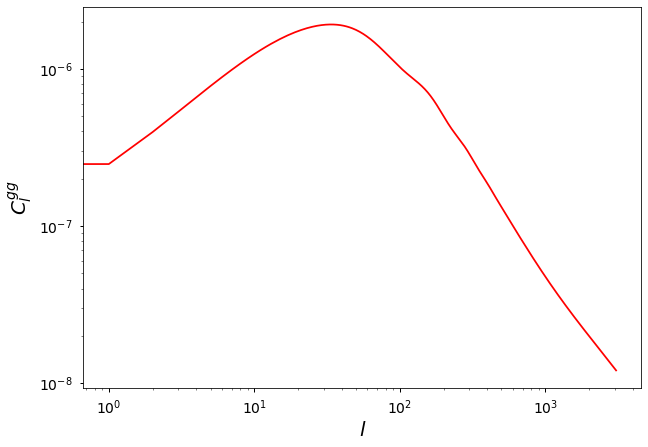

In [6]:
plt.figure(figsize = fsize)
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C^{g g}_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.plot(ell, cls_elg_th, 'r-')

# 2: Generate a realization and noise map

## Realization

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

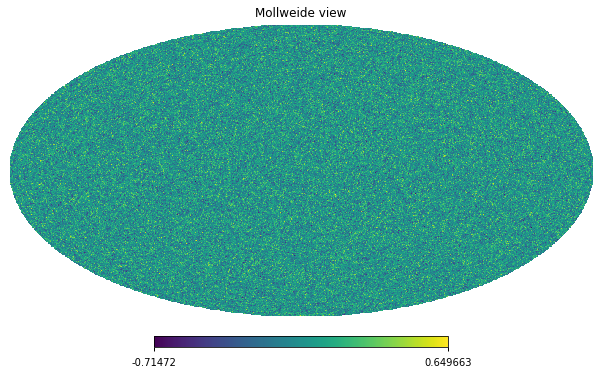

In [7]:
delta_g = hp.synfast(cls_elg_th, nside = NSIDE, pol=False, verbose=False)
hp.mollview(delta_g)

## Noise Map

In [7]:
nbar_sqdeg = 2400 #per deg2
nbar_sr = (np.pi/180)**(-2) * nbar_sqdeg #conversion factor from sq deg to sr. 1 deg2 = 4pi^2/129600 sr
cls_shot_noise = 1/nbar_sr * np.ones_like(ell)

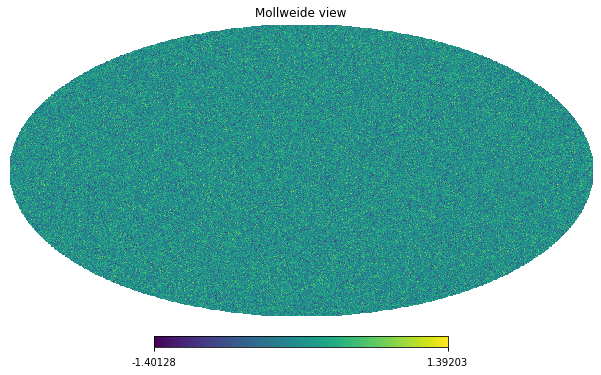

In [85]:
noise_g = hp.synfast(cls_shot_noise, nside = NSIDE, pol = False, verbose = False)
hp.mollview(noise_g)

# 3: Apply imaging systematics 

## Import Mehdi's neural network weight map

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

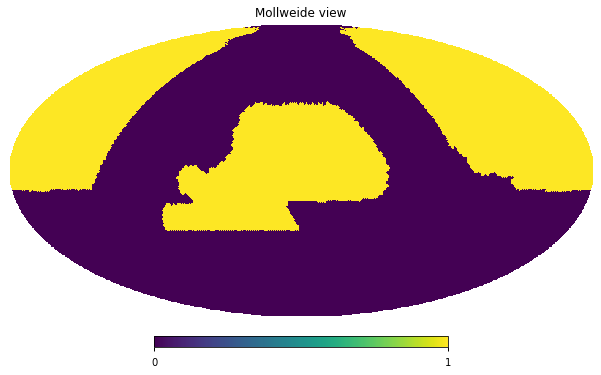

In [98]:
#read in random and degrade it to generate mask
dr_elg_ran = np.load("../dat/elg_ran1024.npy")
dr_elg_ran64 = hp.ud_grade(dr_elg_ran, 64) #make it very coarse to remove weird effects in the middle
dr_elg_ran_final = hp.ud_grade(dr_elg_ran64, NSIDE)

mask = np.copy(dr_elg_ran_final)
mask[dr_elg_ran_final != 0] = 1 #good pixels are 1
mask = mask.astype("bool")
hp.mollview(mask)

In [99]:
# insert at 1, 0 is the script path (or '' in REPL)

from lib import GenSys

gs = GenSys('../dat/nn-weights-combined_1024.fits', nside = NSIDE)          # window functions

#--- contaminate a given density field
tmpF = gs.fetch_window(0)
tmpF = tmpF/np.mean(tmpF[mask > 0])

delta_c = gs.contaminate(tmpF, delta_g, mask, noisemap = noise_g, boss = False)

# of selection functions:  (4805767, 100)


NameError: name 'delta_g' is not defined

### Visualize truth and contaminated maps

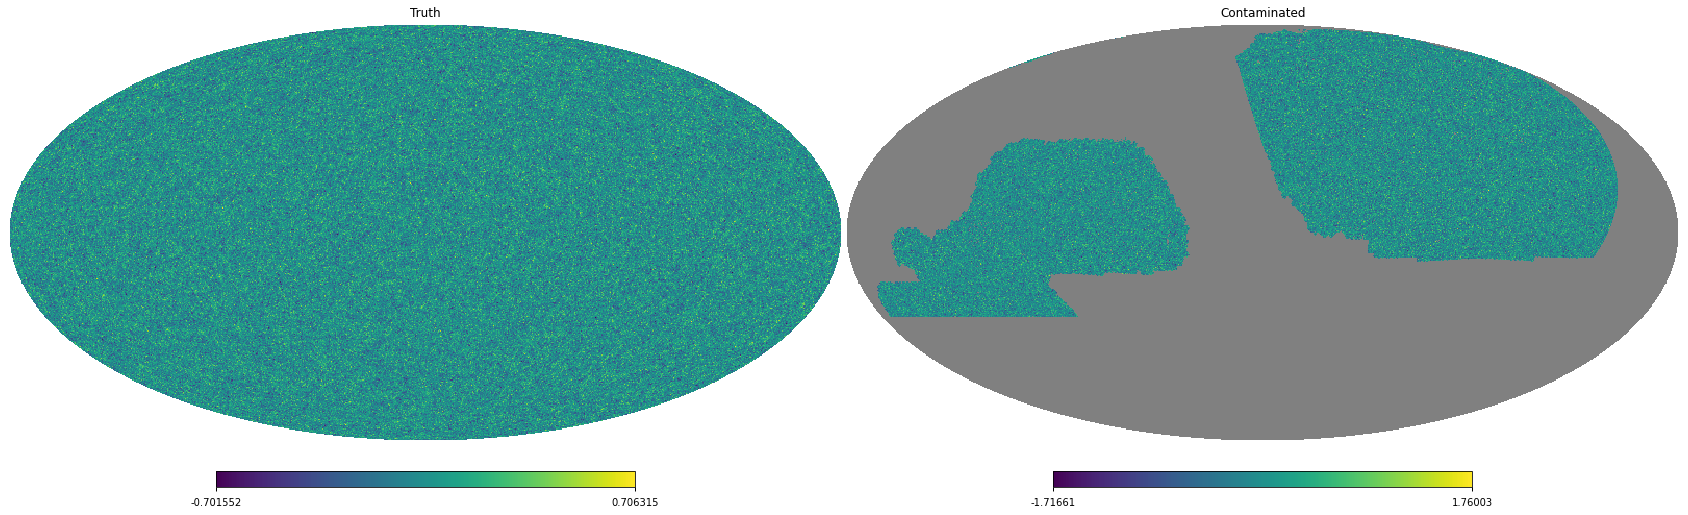

In [12]:
fg, ax = plt.subplots(ncols=2, figsize=(30, 10))
fg.subplots_adjust(wspace=0.0)

for i, (map_i, title_i) in enumerate(zip([delta_g, delta_c],
                                         ['Truth', 'Contaminated'])):
    plt.sca(ax[i])
    hp.mollview(map_i, rot=-85, hold=True, title=title_i)

In [13]:
cls_deltag = hp.anafast(delta_g, lmax=LMAX - 1, pol=False)
cls_deltac = hp.anafast(delta_c, lmax=LMAX - 1, pol=False)

Calculate $f_{\rm sky}$

In [116]:
fsky = np.sum(mask)/mask.size

#calculate window noise
noise_window = np.mean(tmpF)*1/nbar_sr

## Check whether observed $C_l$s match theory $C_l$s

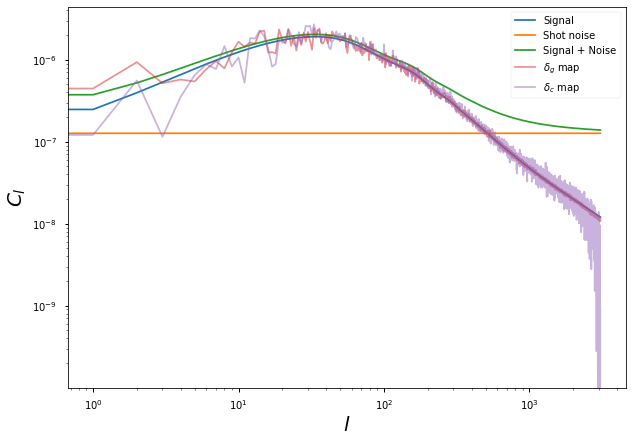

In [15]:
plt.figure(figsize = fsize)
plt.loglog(ell, cls_elg_th, label = 'Signal')
plt.loglog(ell, cl_shot_noise, label = 'Shot noise')
plt.loglog(ell, cls_elg_th + cl_shot_noise, label = 'Signal + Noise')
plt.loglog(ell, cls_deltag, label = r'$\delta_g$ map', alpha = 0.5)
plt.loglog(ell, (cls_deltac - noise_window)/fsky, label = r'$\delta_c$ map', alpha = 0.5)
plt.xlabel("$l$", fontsize = fs)
plt.ylabel("$C_l$", fontsize = fs)
plt.legend(loc = 'best')
plt.show()

(0.5, 1.5)

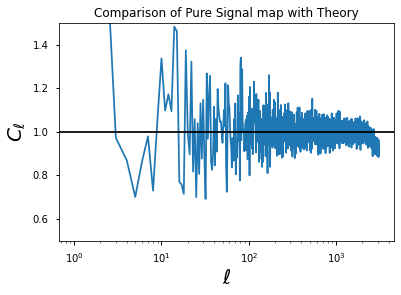

In [16]:
plt.semilogx(ell, cls_deltag/cls_elg_th)
plt.axhline(1, c = 'k')
plt.title("Comparison of Pure Signal map with Theory")
plt.xlabel(r"$\ell$", fontsize = fs)
plt.ylabel(r"$C_{\ell}$", fontsize = fs)
plt.ylim([.5,1.5])

In [17]:
np.mean(cls_deltag/cls_elg_th)

0.9883997349295861

(0.5, 1.5)

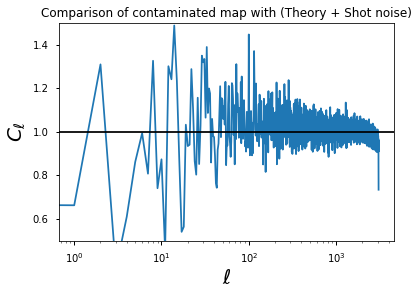

In [18]:
plt.semilogx(ell, ((cls_deltac/fsky)/(cls_elg_th + cl_shot_noise)))
plt.axhline(1, c = 'k')
plt.title("Comparison of contaminated map with (Theory + Shot noise)")
plt.xlabel(r"$\ell$", fontsize = fs)
plt.ylabel(r"$C_{\ell}$", fontsize = fs)
plt.ylim([.5,1.5])

In [19]:
np.mean(((cls_deltac/fsky)/(cls_elg_th + cl_shot_noise)))

1.0022633667921241

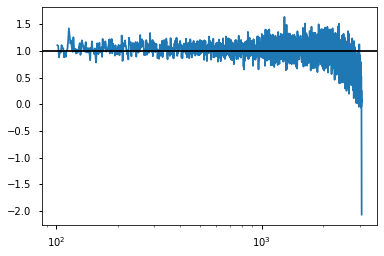

In [20]:
cls_true = cls_deltac/fsky - cl_shot_noise
plt.semilogx(ell[ell > lmin], (cls_true/(cls_elg_th))[ell > lmin])
plt.axhline(1, c = 'k')

In [21]:
np.mean((cls_true/(cls_elg_th))[(ell > lmin) & (ell < LMAX)])

0.9412405248385457

**Observation:** After correcting for shot noise, mean is worse off than before correcting for shot noise. 

## Determine average selection function $<F>$

In [100]:
nselfunc = 100 #number of selection functions
Fmean_pre = np.zeros(nselfunc) #store the mean of each selection function prior to norm correction
Fmean_post = np.zeros(nselfunc) #store the mean of each selection function post norm correction
invFmean_pre = np.zeros(nselfunc) #store mean of each sel func prior to norm correction
invFmean_post = np.zeros(nselfunc) #store mean of each sel func post norm correction
Favg_map = np.zeros(12*NSIDE**2) #store the average selection function

for i in range(nselfunc):
    tmpF = gs.fetch_window(i) #tmp variable to store each call
    maskedMean = np.mean(tmpF[mask > 0]) #temp variable to store mean of each sel. func.
    Fmean_pre[i] = np.mean(tmpF[mask > 0]) #store means of sel. func. 
    invFmean_pre[i] = np.mean(tmpF[tmpF > 0.1])
    
    #Renormalize map to <F> = 1; This is because Mehdi clipped extreme values so <F> != 1
    tmpF = tmpF/maskedMean 
    Fmean_post[i] = np.mean(tmpF[mask > 0])
    invFmean_post[i] = np.mean(tmpF[tmpF > 0.1])
    
    #define running average
    Favg_map = (tmpF + i * Favg_map)/(i + 1) 

In [103]:
print('Pre normalization')
print('------------')
print(f'Fmean -- mean: {np.mean(Fmean_pre)}, low: {np.min(Fmean_pre)}, high: {np.max(Fmean_pre)}')
print(f'invFmean -- mean: {np.mean(invFmean_pre)}, low: {np.min(invFmean_pre)}, high: {np.max(invFmean_pre)}')
print('------------')
print('Post normalization')
print('------------')
print(f'Fmean -- mean: {np.mean(Fmean_post)}, low: {np.min(Fmean_post)}, high: {np.max(Fmean_post)}')
#print(f'Favg_map -- mean: {np.mean(Favg_map[mask>0])}, low: {np.min(Favg_map[mask>0])}, high: {np.max(Favg_map[mask>0])}')
print(f'invFmean -- mean: {np.mean(invFmean_post)}, low: {np.min(invFmean_post)}, high: {np.max(invFmean_post)}')

Pre normalization
------------
Fmean -- mean: 0.9665088125601226, low: 0.9664950518132503, high: 0.9665148216562116
invFmean -- mean: 0.9999985789129908, low: 0.9999843413528794, high: 1.0000047962257266
------------
Post normalization
------------
Fmean -- mean: 1.0, low: 0.9999999999999986, high: 1.0000000000000018
invFmean -- mean: 1.0346502441753833, low: 1.034650244175382, high: 1.0346502441753849


### Visualize average contaminated map

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

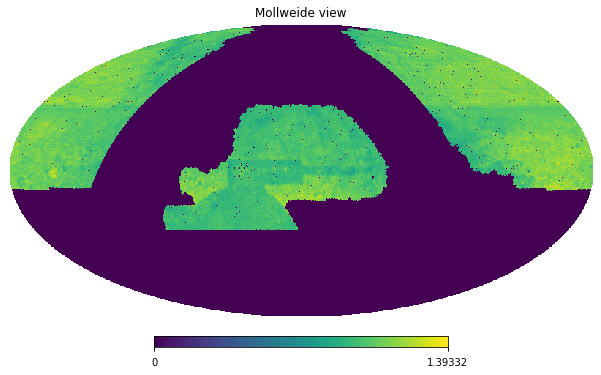

In [38]:
hp.mollview(Favg_map)

Check the variance in $C_{\ell}$s of the imaging systematics

In [111]:
cls_obs_sys = np.zeros((NMOCKS, ell.shape[0]))

seed = 890
for i in range(NMOCKS):
    tmpF = gs.fetch_window(i)
    maskedMean = np.mean(tmpF[mask > 0])
    tmpF = tmpF/maskedMean
    
    #generate overdensity signal mock
    np.random.seed(seed)
    delta_g = hp.synfast(cls_elg_th,
        nside = NSIDE, lmax = LMAX, pol=False, verbose=False)
    
    #contaminate signal map 
    delta_c = gs.contaminate(tmpF, delta_g, mask, noisemap = None)
    
    #calcuate pseudo-Cl
    cls_obs_sys[i] = hp.anafast(delta_c, lmax = LMAX -1, pol = False)
    
    seed = seed + 90

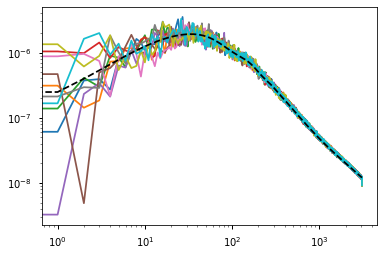

In [118]:
for i in range(10):
    plt.loglog(ell, cls_obs_sys[i]/fsky)
    
plt.loglog(ell, cls_elg_th, ls = '--', c = 'k')

In [130]:
cls_obs_sys.std(axis = 0)

array([1.85704513e-07, 1.32205516e-07, 1.54688008e-07, ...,
       8.95600807e-11, 7.10171117e-11, 7.19998227e-11])

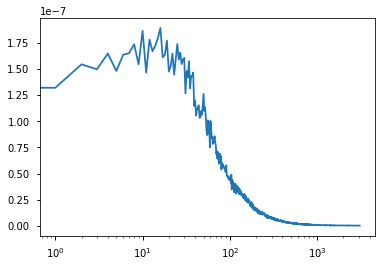

In [137]:
plt.semilogx(ell, cls_obs_sys.std(axis = 0))

# 4: Experiments with different contaminated maps
Here, $F \equiv$ selection function, $\delta_g \equiv$ overdensity map and $N_{s} \equiv$ noise map.

For each experiment, we generate $100$ Gaussian mocks and calculate the covariance matrix. Experiments A, B and C are based on estimator of $\hat{\delta_g}$ based on Equation 3 from Singh 2021; experiments D, E and F are based on Equation 5 from Singh 2021. Note that Equation 5 is normally used for uniform selection function and has been used by BOSS. 

- A: Fixed Window - $<F> \delta_g + \sqrt{<F>} N_{s}$
- B: Variable Window - $F\delta_g + \sqrt{F} N_{s}$
- C: Variable Window - $F (1 + \delta_g) + \sqrt{F} N_{s} - <F>$

- D: Fixed Window - $\delta_g + \sqrt{\frac{1}{<F>}} N_s$
- E: Variable Window - $\delta_g + \sqrt{\frac{1}{F}} N_{s}$
- F: Variable Window - $\frac{F}{<F>} (1 + \delta_g) + \sqrt{\frac{F}{<F>}} N_{s} - 1$

## Experiment A: Fixed Window - $<F> \delta_g + \sqrt{<F>} N_{s}$

In [39]:
from time import time 

In [40]:
def cls_from_mock(cls_th, cls_shot_noise, F, mask, seed, LMAX, NSIDE = 1024, additive = None, boss = False):
    """Generate a mock given conditions and calculate pseudo-Cls from the mock.

    Inputs:
        cls_th (np.array) : array of theory Cl values to be used to generate
                            mock
        cls_shot_noise (np.array) : array of Cl values to be used to generate
                                    noise mock
        F (np.array) : Imaging contaminant map from GenSys. Should be same size
                        as NSIDE
        mask (np.array) : Mask map. Should be same size as NSIDE
        seed (int) : seed for mock generation
        LMAX (int) : lmax to be calculated for pseudo Cl
        NSIDE (int) : nside for healpy
        additive (np.array) : array of average F map used for additive component 
                                experiments
        boss (bool) : add BOSS correction by dividing by the F map 
        

    Returns:
        cls_obs (np.array) : array of pseudo-Cls based on generated mock. Not
                            corrected for fsky
    """

    #generate overdensity signal mock
    np.random.seed(seed)
    delta_g = hp.synfast(cls_th,
        nside = NSIDE, lmax = LMAX, pol=False, verbose=False)

    #generate noise mock
    np.random.seed(2*seed + 1029) #random different seed for noise
    noise_g = hp.synfast(cls_shot_noise,
        nside = NSIDE, lmax = LMAX, pol = False, verbose = False)

    #add img sys
    if additive is not None:
        delta_c = gs.contaminate(F, delta_g, mask, noisemap = noise_g, additive = additive, boss = boss)
    else:
        delta_c = gs.contaminate(window = F, delta = delta_g, mask = mask, noisemap = noise_g, boss = boss)
        
    #calcuate pseudo-Cl
    cls_obs = hp.anafast(delta_c, lmax = LMAX -1, pol = False)

    return cls_obs

In [41]:
cls_obs_A = np.zeros((NMOCKS, LMAX))

#calculate window noise
noise_window_A = np.mean(Favg_map)*1/nbar_sr

#calculate fsky
fsky_A = np.sum(mask)/mask.shape[0] 

#corrected for window noise and fsky
for i in range(NMOCKS):
    cls_obs_A[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = Favg_map, 
              mask = mask, seed = 67 + 2*i, LMAX = LMAX) - noise_window_A)/fsky_A
    if((i % (10)) == 0):
        print(i)

0
10
20
30
40
50
60
70
80
90


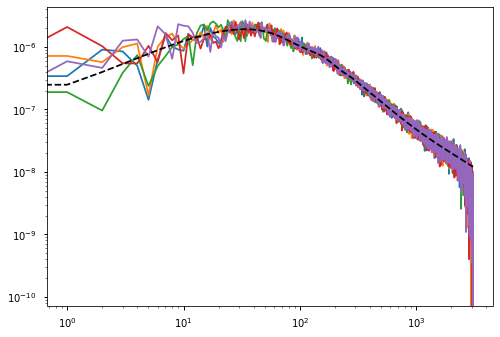

In [77]:
for i in range(5):
    plt.plot(ell, cls_obs_A[i])
    
plt.plot(ell, cls_elg_th, c = 'k', ls = '--')
plt.xscale("log")
plt.yscale("log")

In [42]:
CLs_obs_A = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_A[i] = bin_mat(ell, cls_obs_A[i], ELL)

../src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


### Calculate covariance matrix and visualize

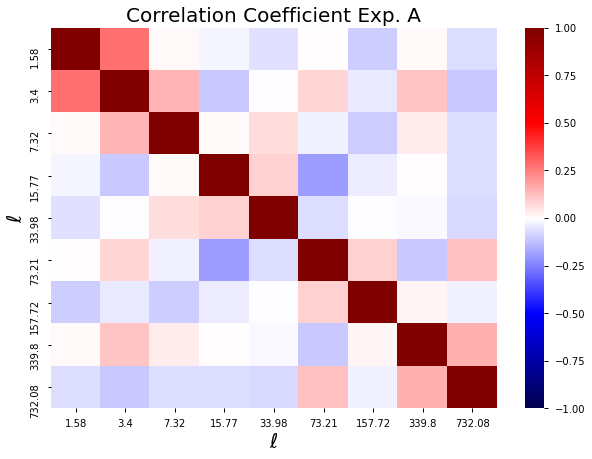

In [43]:
corrcoeff_A = np.corrcoef(CLs_obs_A.T)
ticklabels = np.round(ELL_mid, 2)

heatmap_plot(corrcoeff_A, 'Correlation Coefficient Exp. A', fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

## Experiment B: Variable Window - $F\delta_g + \sqrt{F} N_{s}$

We use the same Gaussian realizations and noise realizations

In [44]:
cls_obs_B = np.zeros((NMOCKS, LMAX))
noise_window_B = np.zeros(NMOCKS)

#calculate fsky
fsky_B = np.sum(mask)/mask.shape[0] 

#corrected for window noise and fsky
for i in range(NMOCKS):
    tmpF = gs.fetch_window(i)
    
    maskedMean = np.mean(tmpF[mask > 0]) #temp variable to store mean of each sel. func.
    tmpF = tmpF/maskedMean #Renormalize map to <F> = 1; This is because Mehdi clipped extreme values so <F> != 1
    
    #calculate window noise
    noise_window_B[i] = np.mean(tmpF)*1/nbar_sr
    
    cls_obs_B[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = tmpF, 
              mask = mask, seed = 670 + 2*i, LMAX = LMAX) - noise_window_B[i])/fsky_B
    if((i % (10)) == 0):
        print(i)

0
10
20
30
40
50
60
70
80
90


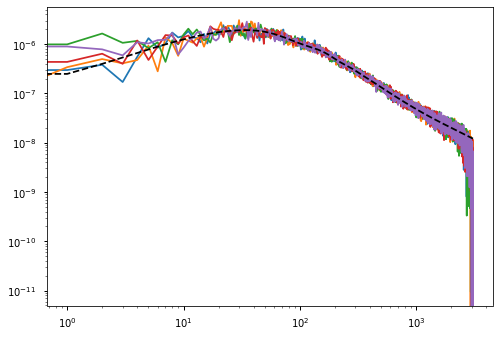

In [76]:
for i in range(5):
    plt.plot(ell, cls_obs_B[i])
    
plt.plot(ell, cls_elg_th, c = 'k', ls = '--')
plt.xscale("log")
plt.yscale("log")

In [45]:
CLs_obs_B = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_B[i] = bin_mat(ell, cls_obs_B[i], ELL)

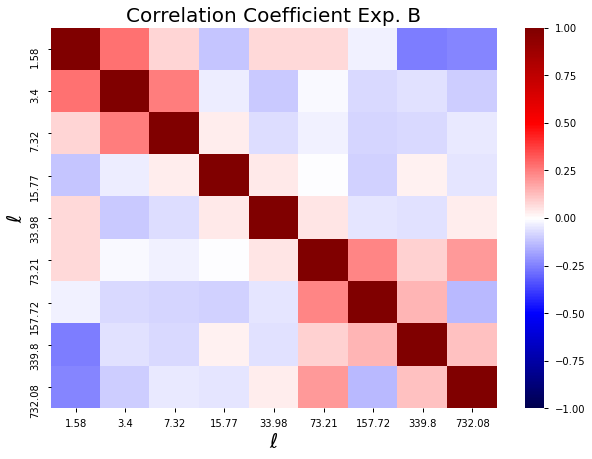

In [46]:
corrcoeff_B = np.corrcoef(CLs_obs_B.T)

heatmap_plot(corrcoeff_B, 'Correlation Coefficient Exp. B', fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

Compare correlation coefficients between Experiments A and B:

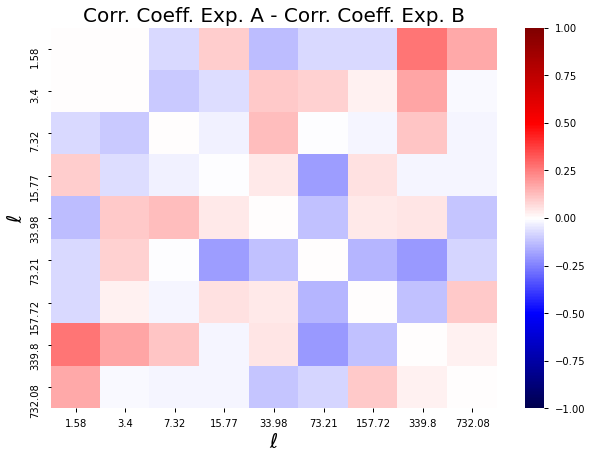

In [47]:
heatmap_plot(corrcoeff_A - corrcoeff_B, 'Corr. Coeff. Exp. A - Corr. Coeff. Exp. B', 
             fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

## Experiment C: Variable Window - $F (1 + \delta_g) + \sqrt{F} N_{s} - <F>$

In [48]:
cls_obs_C = np.zeros((NMOCKS, LMAX))
noise_window_C = np.zeros(NMOCKS)

#calculate fsky
fsky_C = np.sum(mask)/mask.shape[0] 

for i in range(NMOCKS):
    tmpF = gs.fetch_window(i)
    
    maskedMean = np.mean(tmpF[mask > 0]) #temp variable to store mean of each sel. func.
    tmpF = tmpF/maskedMean #Renormalize map to <F> = 1; This is because Mehdi clipped extreme values so <F> != 1
    
    #calculate window noise
    noise_window_C[i] = np.mean(tmpF)*1/nbar_sr
    
    cls_obs_C[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = tmpF, 
              mask = mask, seed = 670 + 2*i, LMAX = LMAX, additive=Favg_map) - noise_window_C[i])/fsky_C
    if((i % (10)) == 0):
        print(i)

0
10
20
30
40
50
60
70
80
90


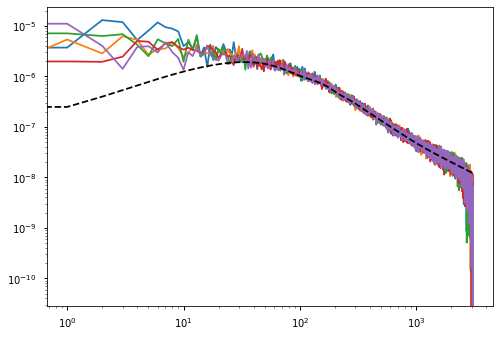

In [75]:
for i in range(5):
    plt.plot(ell, cls_obs_C[i])
    
plt.plot(ell, cls_elg_th, c = 'k', ls = '--')
plt.xscale("log")
plt.yscale("log")

In [49]:
CLs_obs_C = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_C[i] = bin_mat(ell, cls_obs_C[i], ELL)

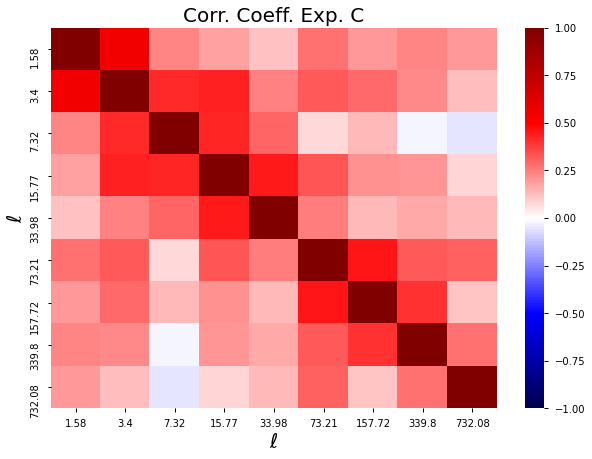

In [50]:
corrcoeff_C = np.corrcoef(CLs_obs_C.T)

heatmap_plot(corrcoeff_C, 'Corr. Coeff. Exp. C', 
             fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

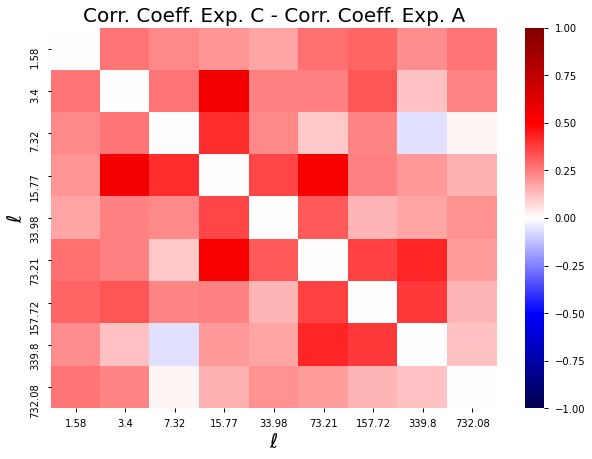

In [51]:
heatmap_plot(corrcoeff_C - corrcoeff_A, 'Corr. Coeff. Exp. C - Corr. Coeff. Exp. A', 
             fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

**Observation:** This makes sense because in this experiment, the errors are on the first order, not just the second order as experiment B.

## Alternate formalism of $\delta_g$ estimator

## Experiment D: Fixed Window - $\delta_g + \sqrt{\frac{1}{<F>}} N_{s}$

This is an alternate definition of the estimator of the overdensity map. In this definition, the effect of the window function is removed by dividing the number count map, $n_g (x)$ with $\bar{n_g} (x)$ and doing the following operation (See Equation 5 in Singh 2021): 

\begin{align}
\hat{\delta_g (x)} &= \frac{n_g (x)}{\bar{n_g} (x)} - 1 \\
&= \frac{n_g (x)}{W_g (x) \bar{n_g}} - 1 \\
&= \delta_g (x)
\end{align}

Ideally, this estimator should yield the same results as the estimator in Experiments A, B and C. However, we notice that the window term in noise is interverted, and as such, we can only consider pixels for which the window values are not too divergent from the mask value, i.e. the window values are strictly non-zero (and above a certain threshold). So for a varying window, the estimator defined here has to be more aggressive than the estimator in Experiments A, B and C because it has to exclude pixels with window value close to $0$. As such, we may lose information from those low window value pixels, which are otherwise considered in estimator introduced for experiments A, B, and C. 

This estimator works best when the window function is non-varying. But to model small-scale effects, this estimator might not be optimal because by ignoring window variations in small-scales, we tend to ignore the systematics introduced by the window function. 

Here, we will measure the effect of this estimator definition. 

In [53]:
cls_obs_D = np.zeros((NMOCKS, LMAX))

#define new mask
tol = 0.8
mask_D = mask & (Favg_map > tol)

#calculate fsky
fsky_D = np.sum(mask_D)/mask_D.shape[0] 

noise_window_D = np.mean(1/Favg_map[mask_D]) * 1/nbar_sr

#corrected for window noise and fsky
for i in range(NMOCKS):
    cls_obs_D[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = Favg_map, 
              mask = mask_D, seed = 67 + 28*i, LMAX = LMAX, boss = True))/fsky_D - noise_window_D
    if((i % (10)) == 0):
        print(i)

0
10
20
30
40
50
60
70
80
90


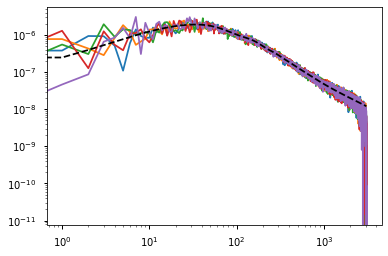

In [55]:
for i in range(5):
    plt.plot(ell, cls_obs_D[i])
    
plt.plot(ell, cls_elg_th, c = 'k', ls = '--')
plt.xscale("log")
plt.yscale("log")

In [56]:
CLs_obs_D = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_D[i] = bin_mat(ell, cls_obs_D[i], ELL)

../src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


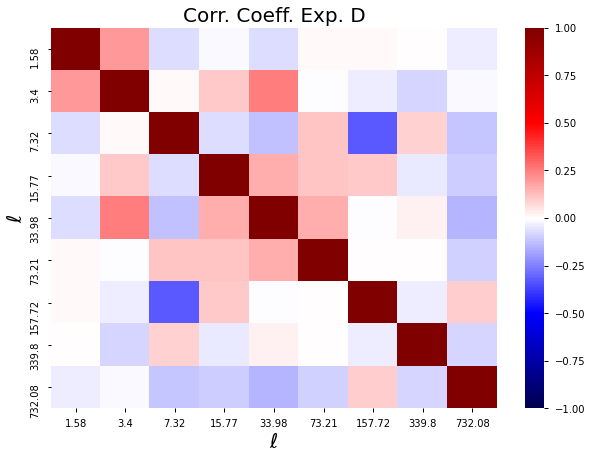

In [57]:
corrcoeff_D = np.corrcoef(CLs_obs_D.T)

heatmap_plot(corrcoeff_D, 'Corr. Coeff. Exp. D', fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

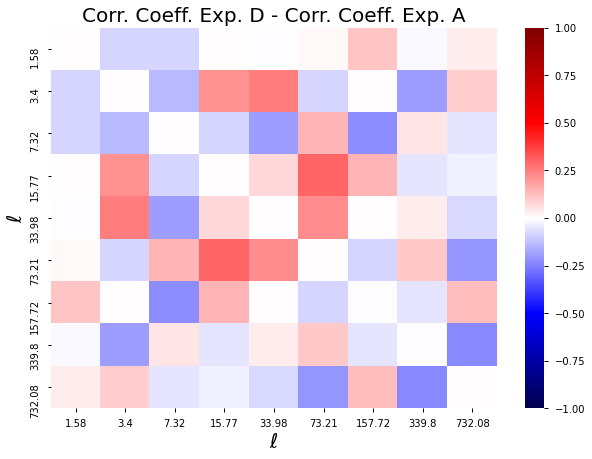

In [58]:
heatmap_plot(corrcoeff_D - corrcoeff_A, 'Corr. Coeff. Exp. D - Corr. Coeff. Exp. A', 
             fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

## Experiment E: Variable Window - $\delta_g + \sqrt{\frac{1}{F}} N_{s}$


In [60]:
cls_obs_E = np.zeros((NMOCKS, LMAX))
noise_window_E = np.zeros(NMOCKS)
fsky_E = np.zeros(NMOCKS)

#corrected for window noise and fsky
for i in range(NMOCKS):
    #normalize systematics maps 
    tmpF = gs.fetch_window(i)
    maskedMean = np.mean(tmpF[mask > 0]) 
    tmpF = tmpF/maskedMean 
    
    #define new mask
    mask_E = mask & (tmpF > tol)
    
    #calculate fsky
    fsky_E[i] = np.sum(mask_E)/mask_E.shape[0]
    
    #calculate window noise
    noise_window_E[i] = np.mean(1/tmpF[mask_E]) * 1/nbar_sr
    
    cls_obs_E[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = tmpF, 
              mask = mask_E, seed = 68 + 280*i, LMAX = LMAX, boss = True))/fsky_E[i] - noise_window_E[i]
    if((i % (10)) == 0):
        print(i)

0
10
20
30
40
50
60
70
80
90


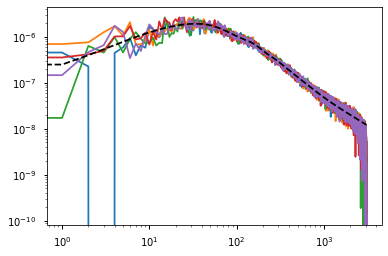

In [61]:
for i in range(5):
    plt.plot(ell, cls_obs_E[i])
    
plt.plot(ell, cls_elg_th, c = 'k', ls = '--')
plt.xscale("log")
plt.yscale("log")

In [62]:
CLs_obs_E = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_E[i] = bin_mat(ell, cls_obs_E[i], ELL)

../src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


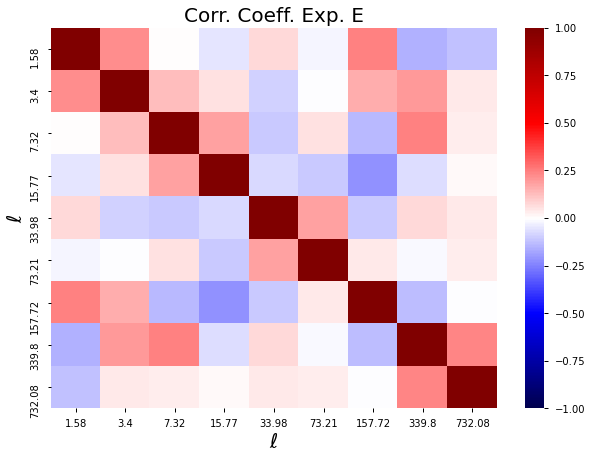

In [63]:
corrcoeff_E = np.corrcoef(CLs_obs_E.T)

heatmap_plot(corrcoeff_E, 'Corr. Coeff. Exp. E', fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

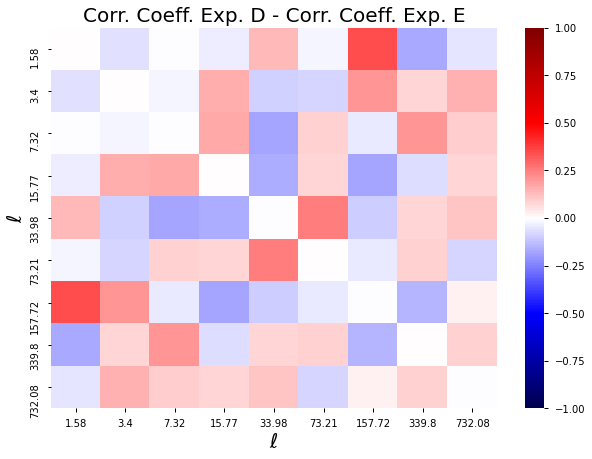

In [64]:
heatmap_plot(corrcoeff_E - corrcoeff_A, 'Corr. Coeff. Exp. D - Corr. Coeff. Exp. E', 
             fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

## Experiment F: Variable Window - $\frac{F}{<F>} (1 + \delta_g) + \sqrt{\frac{F}{<F>}} N_{s} - 1$


In [69]:
cls_obs_F = np.zeros((NMOCKS, LMAX))
#noise_window_F = np.zeros(NMOCKS)
#fsky_F = np.zeros(NMOCKS)
noise_window_F = noise_window_E #same; using this to speed up loop
fsky_F = fsky_E #same; using this to speed up loop

#corrected for window noise and fsky
for i in range(NMOCKS):
    #normalize systematics maps 
    tmpF = gs.fetch_window(i)
    maskedMean = np.mean(tmpF[mask > 0]) 
    tmpF = tmpF/maskedMean 
    
    #define new mask
    mask_F = mask & (tmpF > tol)
    
    #calculate fsky
    #fsky_F[i] = np.sum(mask_F)/mask_F.shape[0]
    
    #calculate window noise
    #noise_window_E[i] = np.mean(1/tmpF[mask_E]) * 1/nbar_sr
    
    cls_obs_F[i] = (cls_from_mock(cls_th = cls_elg_th, cls_shot_noise=cl_shot_noise, F = tmpF, 
              mask = mask_F, seed = 618 + 180*i, LMAX = LMAX, additive=Favg_map, 
                                  boss = True))/fsky_F[i] - noise_window_F[i]
    if((i % (10)) == 0):
        print(i)

0
10
20
30
40
50
60
70
80
90


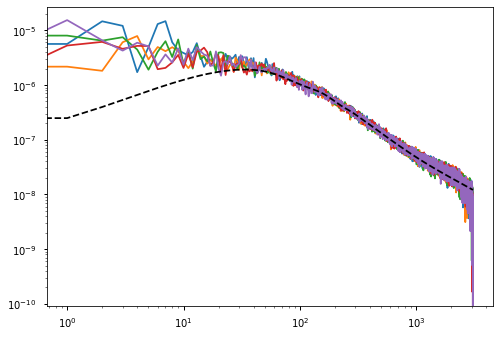

In [70]:
for i in range(5):
    plt.plot(ell, cls_obs_F[i])
    
plt.plot(ell, cls_elg_th, c = 'k', ls = '--')
plt.xscale("log")
plt.yscale("log")

**Observation:** Extra power at low $\ell$s

In [71]:
CLs_obs_F = np.zeros((NMOCKS, 9))

for i in range(NMOCKS):
    ELL_mid, CLs_obs_F[i] = bin_mat(ell, cls_obs_F[i], ELL)

../src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


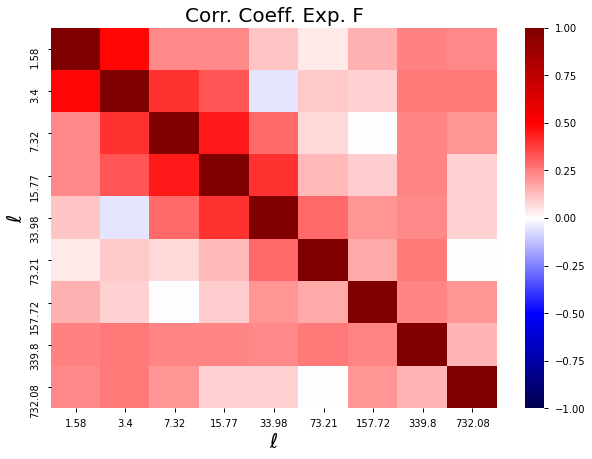

In [72]:
corrcoeff_F = np.corrcoef(CLs_obs_F.T)

heatmap_plot(corrcoeff_F, 'Corr. Coeff. Exp. F', fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

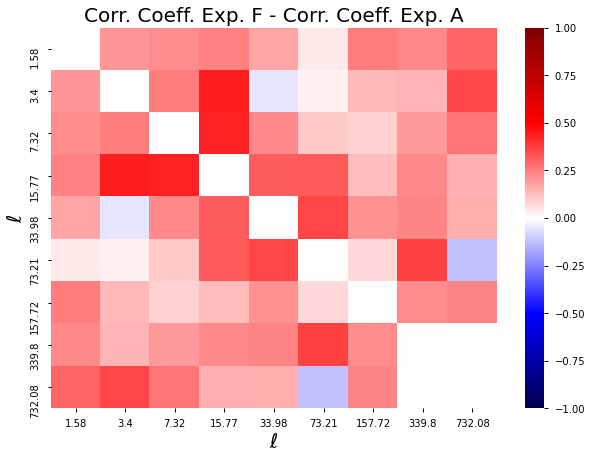

In [73]:
heatmap_plot(corrcoeff_F - corrcoeff_A, 'Corr. Coeff. Exp. F - Corr. Coeff. Exp. A', 
             fsize, xticklabels=ticklabels, 
            yticklabels=ticklabels)

Save the covariance matrices

In [8]:
#cls
np.save("../dat/cls_expA.npy", cls_obs_A)
np.save("../dat/cls_expB.npy", cls_obs_B)
np.save("../dat/cls_expC.npy", cls_obs_C)
np.save("../dat/cls_expD.npy", cls_obs_D)
np.save("../dat/cls_expE.npy", cls_obs_E)
np.save("../dat/cls_expF.npy", cls_obs_F)

NameError: name 'cls_obs_A' is not defined

## Load saved cov matrices and use them for comparison

In [26]:
exp_names = np.array(['A', 'B', 'C', 'D', 'E', 'F'])
experiments = {}

#dict to store values
for name in exp_names:
    experiments[name] = {}

#load cls from memory
for key in experiments:
    experiments[key]['cls_obs'] = np.load("../dat/cls_exp" + key + ".npy")
    experiments[key]['CLs_obs'] = np.zeros((NMOCKS, ELL.shape[0] - 1))
    
#bin power spectrum
for key in experiments:
    for i in range(NMOCKS):
        ELL_mid, experiments[key]['CLs_obs'][i] = bin_mat(ell, experiments[key]['cls_obs'][i], ELL)

../src/lib.py:171: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mat_t=mat_r_dr[slc]


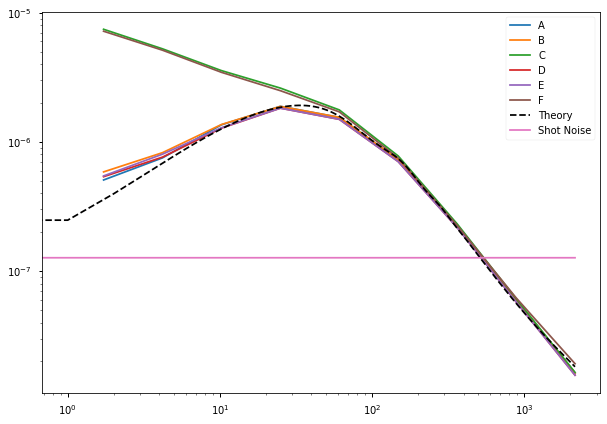

In [27]:
plt.figure(figsize=fsize)
for key in experiments:
    plt.loglog(ELL_mid, experiments[key]['CLs_obs'].mean(axis = 0), label = key)

plt.loglog(ell[(ell < ELL_mid[-1])], (cls_elg_th)[(ell < ELL_mid[-1])],
           ls = '--', c = 'k', label = 'Theory')
plt.loglog(ell[(ell < ELL_mid[-1])], cls_shot_noise[(ell < ELL_mid[-1])], label = 'Shot Noise')
plt.legend(loc = 'best')

In [28]:
def matrix_cut(mat=[],x=[]):
    """
    mat : covariance matrix
    x : l cuts to be applied to mat
    """
    m=mat[x]
    N=sum(x)
    m2=np.zeros((N,N))
    j=0
    for i in m:
        m2[j]=i[x]
        j=j+1
    return m2

def SN_cum(cov=[],lb=[],cl=[],diag=False,lmin=2,lmax=1e4,use_hartlap=False,nsim=1000):
    """
    cov : covariance matrix
    lb : bin centres 
    cl : binned cl array
    """
    
    sni=np.zeros_like(lb)
    for i in np.arange(len(lb)):
        if lb[i]<lmin or lb[i]>lmax:
            continue
        x=lb<=lb[i]
        x*=lb>lmin
        cov2_cut=matrix_cut(mat=cov,x=x)
        if diag:
            cov2_cut=np.diag(np.diag(cov2_cut))
        cov2_cut_inv=np.linalg.inv(cov2_cut)
        
        cl_i=cl[x]
        SN2=cl_i@cov2_cut_inv@cl_i
        if use_hartlap:
            SN2*=(nsim-2-x.sum())/(nsim-1)
        sni[i]=SN2
    return np.sqrt(sni)

In [30]:
for key in experiments: 
    experiments[key]['covmat'] = np.cov(experiments[key]['CLs_obs'].T)
    experiments[key]['SN_cum'] = SN_cum(experiments[key]['covmat'], ELL_mid, 
                                       experiments[key]['CLs_obs'].mean(axis = 0), lmax = LMAX,
                                       use_hartlap=True, nsim = NMOCKS)

Text(0, 0.5, 'SN$(\\ell_{\\rm max})$')

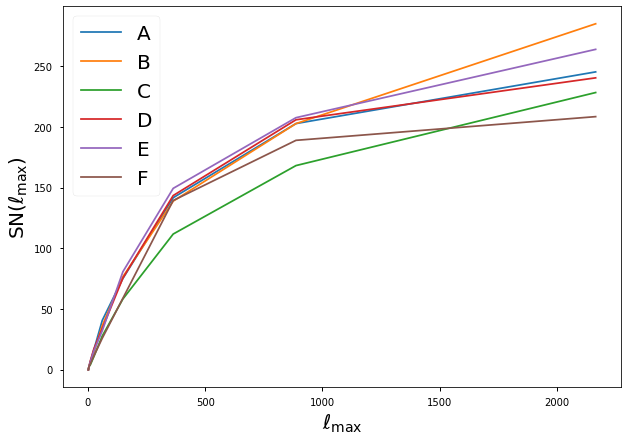

In [31]:
plt.figure(figsize = fsize)
for key in experiments: 
    plt.plot(ELL_mid, experiments[key]['SN_cum'], label = key)
    
plt.legend(loc = 'best', fontsize = fs)
plt.xlabel(r"$\ell_{\rm max}$", fontsize = fs)
plt.ylabel(r"SN$(\ell_{\rm max})$", fontsize = fs)

Text(0, 0.5, 'SN$(\\ell_{\\rm max})$')

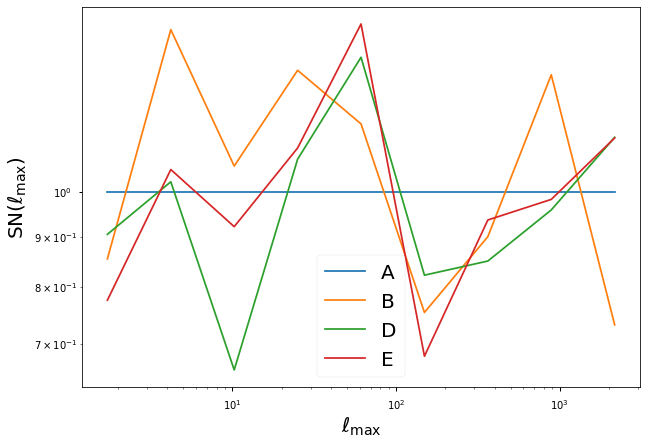

In [35]:
plt.figure(figsize = fsize)
for key in ['A', 'B', 'D', 'E']:
    plt.loglog(ELL_mid, np.diag(experiments[key]['covmat'])/np.diag(experiments['A']['covmat']), label = key)
    
plt.legend(loc = 'best', fontsize = fs)
plt.xlabel(r"$\ell_{\rm max}$", fontsize = fs)
plt.ylabel(r"SN$(\ell_{\rm max})$", fontsize = fs)

## Test with SFD EBV map

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to mod

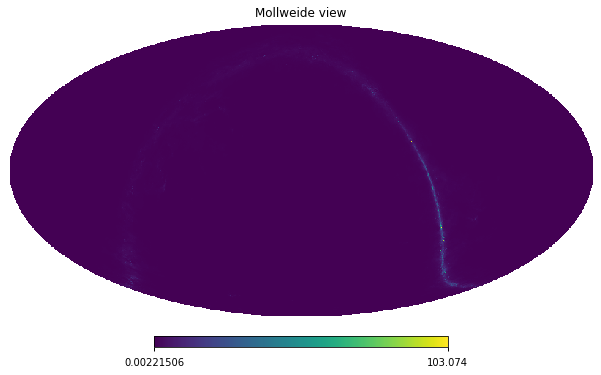

In [100]:
ebv = hp.read_map("../dat/healSFD_256_fullsky.fits", )

hp.mollview(ebv)

### Clean mock X EBV

In [101]:
cl_clean_ebv = hp.anafast(delta_g[0], ebv, lmax = lmax - 1)

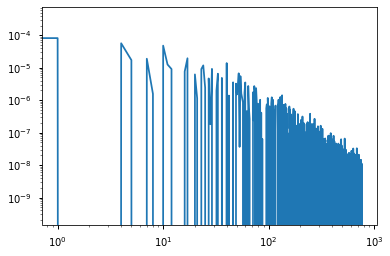

In [103]:
plt.loglog(ell, cl_clean_ebv)

### Contaminated mock X EBV

In [104]:
cl_contam_ebv = hp.anafast(delta_c[0], ebv, lmax = lmax - 1)

(-5.0, 10.0)

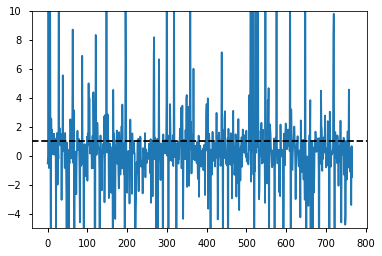

In [112]:
plt.plot(ell, cl_contam_ebv/cl_clean_ebv)
plt.axhline(1, c = 'k', ls = '--')
plt.ylim([-5, 10])

### Window X EBV

In [120]:
cl_win_ebv = hp.anafast(gs.fetch_window(0), ebv, lmax = lmax - 1)

(-5.0, 10.0)

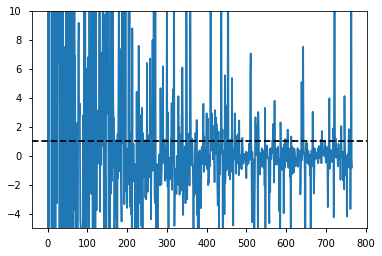

In [121]:
plt.plot(ell, cl_win_ebv/cl_clean_ebv)
plt.axhline(1, c = 'k', ls = '--')
plt.ylim([-5, 10])

In [ ]:
plt.figure(figsize = fsize)
plt.loglog(ell, cl_clean_ebv, alpha = 0.5, label = 'Clean X EBV')
plt.loglog(ell, cl_contam_ebv, alpha = 0.5, label = 'Contaminated X EBV')
plt.loglog(ell, cl_win_ebv, alpha = 0.5, label = 'Window X EBV')
plt.xlabel("l", fontsize = fs)
plt.ylabel(r"$C_{l}^{EBV \times \delta}$", fontsize = fs)
plt.legend(loc = 'best')